In [ ]:
# install all libraries which support the technical analysis
!pip install yfinance matplotlib
!pip install ta
!pip install mplfinance

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29413 sha256=dac5c54076452b741c07719d547636f1de5d4ef46fa9ae7aeb9a453de5cfe0ec
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.7 MB/s eta 0:00:00


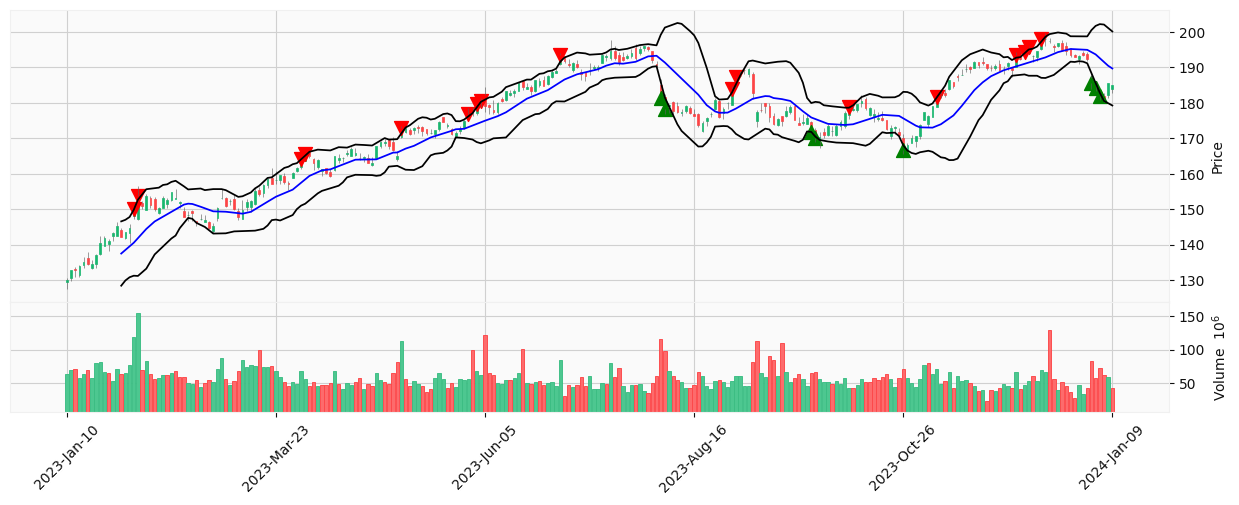

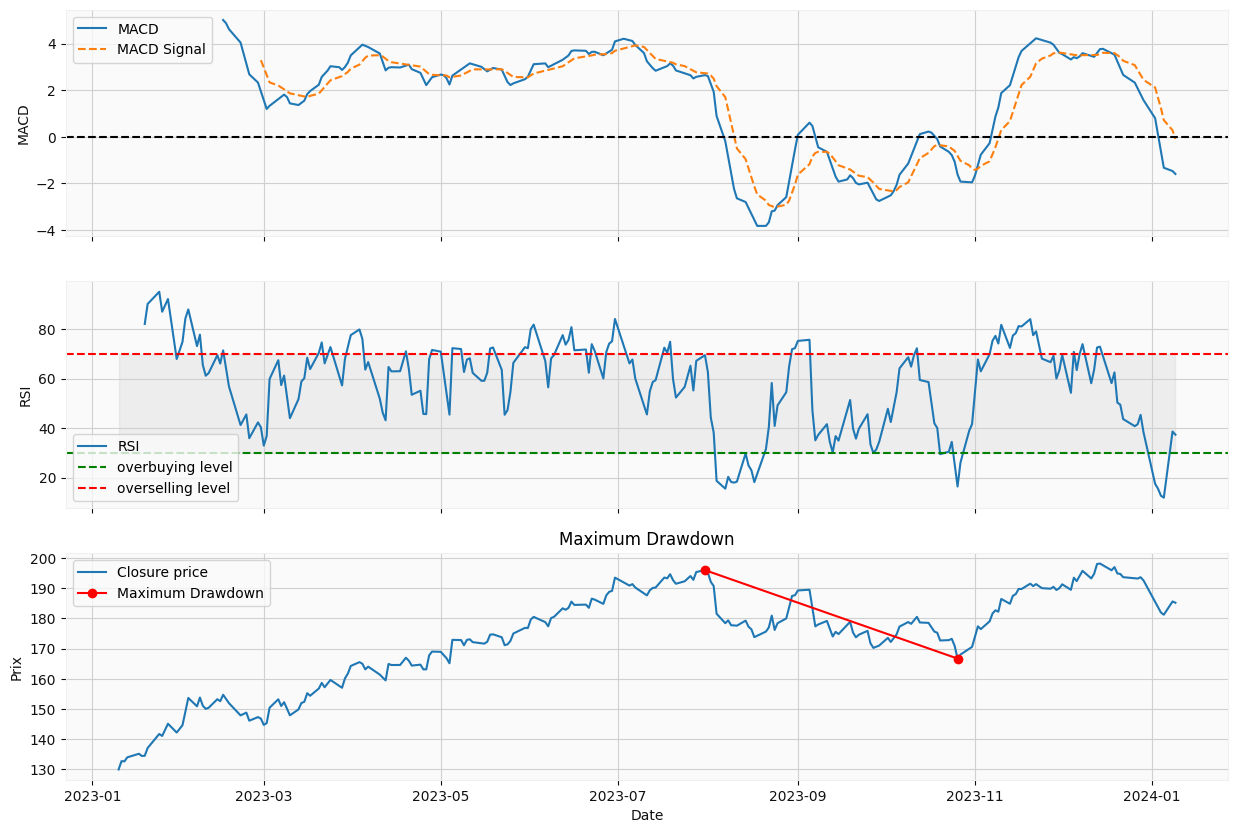

Maximum Drawdown: -14.932366292326119 %
Start Date: 2023-10-26 00:00:00-04:00
End Date: 2023-07-31 00:00:00-04:00
Total Investi est: 1815.0546264648438
Total profit from trading: 24.303390502929688
le rendement de 10 action est : 13.39%
[181.50546264648438, 171.73374938964844, 166.67042541503906, 185.63999938964844] [183.87774658203125, 178.75450134277344, 181.58078002929688]


In [ ]:
# importation of libraries
import yfinance as yf
import matplotlib.pyplot as plt
import mplfinance as mpf
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from scipy.signal import find_peaks
import numpy as np
from ta.trend import MACD

# set asset example
ticker_symbol = 'AAPL'  #Apple

# Acces to the asset prices
ticker_data = yf.Ticker(ticker_symbol)
ticker_df = ticker_data.history(period='12mo',interval='1d')

# Preparation for the jap candles
ohlc = ticker_df[['Open','High','Low','Close']].copy()

# SMA (short moving average)
sma_short_period = 14
sma_long_period = 30
ticker_df['SMA'] = ticker_df['Close'].rolling(window=sma_short_period).mean()

# RSI (Relative Strength Indicator)
rsi_period = 7
ticker_df['RSI'] = RSIIndicator(ticker_df['Close'], window=rsi_period).rsi()

# BB (Bollinger Bands)
bb_indicator = BollingerBands(ticker_df['Close'], window=sma_short_period, window_dev=2)
ticker_df['BB_Upper'] = bb_indicator.bollinger_hband()
ticker_df['BB_Lower'] = bb_indicator.bollinger_lband()

# MACD (Moving Average Convergence Divergence)
macd_indicator = MACD(ticker_df['Close'], window_slow=26, window_fast=12, window_sign=9)
ticker_df['MACD'] = macd_indicator.macd()
ticker_df['MACD_Signal'] = macd_indicator.macd_signal()

# Define the buying or selling signals
ticker_df['Buy'] = (
    (ticker_df['Close'] < ticker_df['BB_Lower']) &
    (ticker_df['RSI'] < 40)
)
ticker_df['Sell'] = (
    (ticker_df['Close'] > ticker_df['BB_Upper']) &
    (ticker_df['RSI'] > 60)
)

# Calculate the Maximum Drawdown
rolling_max = ticker_df['Close'].cummax()
drawdown = (ticker_df['Close'] - rolling_max) / rolling_max
max_drawdown = drawdown.min()

# Find the MDD dates
start_date = drawdown.idxmin()
end_date = ticker_df['Close'][:start_date].idxmax()

# # creat the jap chandler graphic and buying and selling signals
ticker_df['Buy_Signal'] = np.where(ticker_df['Buy'], ticker_df['Close'], np.nan)
ticker_df['Sell_Signal'] = np.where(ticker_df['Sell'], ticker_df['Close'], np.nan)
apds = [mpf.make_addplot(ticker_df['SMA'], color='blue'),
        mpf.make_addplot(ticker_df['BB_Upper'], color='black'),
        mpf.make_addplot(ticker_df['BB_Lower'], color='black'),
        mpf.make_addplot(ticker_df['Buy_Signal'], type='scatter', markersize=100, marker='^', color='green', panel=0),
        mpf.make_addplot(ticker_df['Sell_Signal'], type='scatter', markersize=100, marker='v', color='red', panel=0)]
mpf.plot(ticker_df, type='candle', addplot=apds, figratio=(2.8,1), style='yahoo', volume=True, panel_ratios=(8,3))


# Plotting
fig, (ax2, ax3, ax4) = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

# MACD
ax2.plot(ticker_df['MACD'], label='MACD')
ax2.plot(ticker_df['MACD_Signal'], label='MACD Signal', linestyle='--')
ax2.axhline(0, color='black', linestyle='--')
ax2.set_ylabel('MACD')
ax2.legend()

# RSI
ax3.plot(ticker_df['RSI'], label='RSI')
ax3.axhline(30, color='green', linestyle='--', label='overbuying level')
ax3.axhline(70, color='red', linestyle='--', label='overselling level')
ax3.fill_between(ticker_df.index, 30, 70, alpha=0.1, color='grey')
ax3.set_ylabel('RSI')
ax3.legend()

# MDD
ax4.plot(ticker_df['Close'], label='Closure price')
ax4.plot([start_date, end_date], [ticker_df['Close'].loc[start_date], ticker_df['Close'].loc[end_date]], 'ro-', label='Maximum Drawdown')
ax4.set_xlabel('Date')
ax4.set_ylabel('Prix')
ax4.set_title('Maximum Drawdown')
ax4.legend()

plt.xlabel('Date')
plt.show()

# Show the MDD
print("Maximum Drawdown:", max_drawdown*100,"%")
print("Start Date:", start_date)
print("End Date:", end_date)

buy_price = None
sell_price = None
buy_price_affichage=[]
sell_price_affichage=[]
profits = []
quantité = 10
# Loop through the DataFrame
for i in range(len(ticker_df)):
    # Check if we have a buy signal and haven't already bought
    if ticker_df['Buy'].iloc[i] == True and buy_price is None:
        buy_price = ticker_df['Close'].iloc[i]
        buy_price_affichage.append(ticker_df['Close'].iloc[i])

    # Check if we have a sell signal and have already bought
    if ticker_df['Sell'].iloc[i] == True and buy_price is not None:
        sell_price = ticker_df['Close'].iloc[i]
        sell_price_affichage.append(ticker_df['Close'].iloc[i])
        profit = sell_price - buy_price
        profits.append(profit)
        buy_price = None  # Reset buy_price for the next trade

# Sum up the profits
total_profit = sum(profits)
rendement = total_profit/buy_price_affichage[0]
print(f"Total Investi est: {quantité*buy_price_affichage[0]}")
print(f"Total profit from trading: {total_profit}")
print(f"The profit rate is : {round(rendement*100,2)}%")

print(buy_price_affichage, sell_price_affichage)

In [ ]:
# we define our strategie in a bot_trading fucntion in order to calculte the total return of our asset list
# this function is exactly the same function that we did before without plotting graphics
def bot_trading(ticker_symbol, period='12mo', interval='1d', sma_short_period=14, sma_long_period=30, rsi_period=7):
    ticker_data = yf.Ticker(ticker_symbol)
    ticker_df = ticker_data.history(period=period, interval=interval)

    ticker_df['SMA'] = ticker_df['Close'].rolling(window=sma_short_period).mean()
    ticker_df['RSI'] = RSIIndicator(ticker_df['Close'], window=rsi_period).rsi()
    bb_indicator = BollingerBands(ticker_df['Close'], window=sma_short_period, window_dev=2)
    ticker_df['BB_Upper'] = bb_indicator.bollinger_hband()
    ticker_df['BB_Lower'] = bb_indicator.bollinger_lband()
    macd_indicator = MACD(ticker_df['Close'])
    ticker_df['MACD'] = macd_indicator.macd()
    ticker_df['MACD_Signal'] = macd_indicator.macd_signal()

    ticker_df['Buy'] = (ticker_df['Close'] < ticker_df['BB_Lower']) & (ticker_df['RSI'] < 40)
    ticker_df['Sell'] = (ticker_df['Close'] > ticker_df['BB_Upper']) & (ticker_df['RSI'] > 60)

    rolling_max = ticker_df['Close'].cummax()
    drawdown = (ticker_df['Close'] - rolling_max) / rolling_max
    max_drawdown = drawdown.min()

    start_date = drawdown.idxmin()
    end_date = ticker_df['Close'][:start_date].idxmax()

    ticker_df['Buy_Signal'] = np.where(ticker_df['Buy'], ticker_df['Close'], np.nan)
    ticker_df['Sell_Signal'] = np.where(ticker_df['Sell'], ticker_df['Close'], np.nan)

    buy_price = None
    sell_price = None
    buy_price_affichage=[]
    sell_price_affichage=[]
    profits = []
    quantité = 5

    for i in range(len(ticker_df)):
      if ticker_df['Buy'].iloc[i] == True and buy_price is None:
           buy_price = ticker_df['Close'].iloc[i]
           buy_price_affichage.append(ticker_df['Close'].iloc[i])

      if ticker_df['Sell'].iloc[i] == True and buy_price is not None:
            sell_price = ticker_df['Close'].iloc[i]
            sell_price_affichage.append(ticker_df['Close'].iloc[i])
            profit = sell_price - buy_price
            profits.append(profit)
            buy_price = None

    total_profit = sum(profits)
    rendement = total_profit/buy_price_affichage[0]

    # print(f'Les prix dachat sont : {buy_price_affichage}')
    # print(f'Les prix de ventes sont : {sell_price_affichage}')

    # Return the trading results
    return {
        'Total_Investi':quantité*buy_price_affichage[0],
        'total_profit': total_profit,
        'profits': profits,
        'return_10_actions(en %)' :round(rendement*100,5),
        'max_drawdown': max_drawdown,
        'start_date': start_date,
        'end_date': end_date
    }


bot_trading('BRK-A')

{'Total_Investi': 2292475.0,
 'total_profit': 93932.0,
 'profits': [21720.0, 29334.0, 18555.0, 24323.0],
 'return_10_actions(en %)': 20.48703,
 'max_drawdown': -0.10602177692768078,
 'start_date': Timestamp('2023-10-27 00:00:00-0400', tz='America/New_York'),
 'end_date': Timestamp('2023-09-19 00:00:00-0400', tz='America/New_York')}

In [ ]:
# example of a assets_list
assets_list = [
    {'name': 'Apple', 'ticker': 'AAPL'}, # NASDAQ
    {'name': 'Microsoft', 'ticker': 'MSFT'}, # NASDAQ
    {'name': 'Google', 'ticker': 'GOOGL'}, # NASDAQ
    {'name': 'Amazon', 'ticker': 'AMZN'}, # NASDAQ
    {'name': 'Facebook', 'ticker': 'META'}, # NASDAQ
    {'name': 'Tesla', 'ticker': 'TSLA'}, # NASDAQ
    {'name': 'Berkshire Hathaway', 'ticker': 'BRK-A'}, # NYSE
    {'name': 'Visa', 'ticker': 'V'}, # NYSE
    {'name': 'JPMorgan Chase', 'ticker': 'JPM'}, # NYSE
    {'name': 'Johnson & Johnson', 'ticker': 'JNJ'}, # NYSE
    {'name': 'Walmart', 'ticker': 'WMT'}, # NYSE
    {'name': 'UnitedHealth Group', 'ticker': 'UNH'}, # NYSE
    {'name': 'Mastercard', 'ticker': 'MA'}, # NYSE
    {'name': 'Procter & Gamble', 'ticker': 'PG'}, # NYSE
    {'name': 'LVMH', 'ticker': 'MC.PA'}, # Euronext Paris
    {'name': 'TotalEnergies', 'ticker': 'TTE.PA'}, # Euronext Paris
    {'name': 'Deutsche Telekom', 'ticker': 'DTE.DE'}, # Xetra
    {'name': 'Volkswagen Group', 'ticker': 'VOW.DE'}, # Xetra
    {'name': 'SAP', 'ticker': 'SAP.DE'}, # Xetra
    {'name': 'Siemens', 'ticker': 'SIE.DE'}, # Xetra
    {'name': 'HSBC Holdings', 'ticker': 'HSBA.L'}, # London Stock Exchange
    {'name': 'AstraZeneca', 'ticker': 'AZN.L'}, # London Stock Exchange
    {'name': 'Royal Dutch Shell', 'ticker': 'SHEL'}, # London Stock Exchange
    {'name': 'BHP Group', 'ticker': 'BHP.L'}, # London Stock Exchange
    {'name': 'Rio Tinto', 'ticker': 'RIO.L'}, # London Stock Exchange
    {'name': 'Toyota', 'ticker': '7203.T'}, # Tokyo Stock Exchange
    {'name': 'SoftBank Group', 'ticker': '9984.T'}, # Tokyo Stock Exchange
    {'name': 'Sony', 'ticker': '6758.T'}, # Tokyo Stock Exchange
    {'name': 'Samsung Electronics', 'ticker': '005930.KS'}, # Korea Exchange
    {'name': 'Hyundai Motor Company', 'ticker': '005380.KS'}, # Korea Exchange
    {'name': 'Tencent Holdings', 'ticker': '0700.HK'}, # Hong Kong Stock Exchange
    {'name': 'Alibaba Group', 'ticker': '9988.HK'}, # Hong Kong Stock Exchange
]

list_take_profit=[]
list_return=[]
Total_portefeuille=0

# Calcul des take profit
for asset in assets_list:
  ticker=asset['ticker']
  list_take_profit.append(bot_trading(ticker))
  print(bot_trading(ticker))

rendement_moy = 0
sum_take_profit = 0
for element in list_take_profit:
  sum_take_profit+=element['total_profit']
  Total_portefeuille+=element['Total_Investi']
  list_return.append(element['return_10_actions(en %)'])

print("------------------------------------")

print(f'Total Asset Portefeuille of our strategie:{Total_portefeuille}')
print(f'Total Take Profit of our strategie: {sum_take_profit}')
print(f'The final Return of our strategie: {sum_take_profit/Total_portefeuille*100}%')
print(list_return)


{'Total_Investi': 907.5273132324219, 'total_profit': 24.303390502929688, 'profits': [2.372283935546875, 7.020751953125, 14.910354614257812], 'return_10_actions(en %)': 13.38989, 'max_drawdown': -0.14932366292326119, 'start_date': Timestamp('2023-10-26 00:00:00-0400', tz='America/New_York'), 'end_date': Timestamp('2023-07-31 00:00:00-0400', tz='America/New_York')}
{'Total_Investi': 1368.4156799316406, 'total_profit': 38.256195068359375, 'profits': [29.224517822265625, 9.03167724609375], 'return_10_actions(en %)': 13.97828, 'max_drawdown': -0.12987603604138104, 'start_date': Timestamp('2023-09-26 00:00:00-0400', tz='America/New_York'), 'end_date': Timestamp('2023-07-18 00:00:00-0400', tz='America/New_York')}
{'Total_Investi': 591.6999816894531, 'total_profit': 16.18000030517578, 'profits': [6.200004577636719, 9.979995727539062], 'return_10_actions(en %)': 13.67247, 'max_drawdown': -0.17273065694583306, 'start_date': Timestamp('2023-02-24 00:00:00-0500', tz='America/New_York'), 'end_date'

In [ ]:
# calculation of sharp ratio

def sharpe_ratio(returns_list, risk_free_rate):
    # Convert returns list to a numpy array and risk-free rate to decimal
    portfolio_returns = np.array(returns_list)
    risk_free_rate_decimal = risk_free_rate / 100

    # Calculate the mean of the excess returns (portfolio returns minus the risk-free rate)
    excess_returns = portfolio_returns - risk_free_rate_decimal
    mean_excess_return = excess_returns.mean()

    # Calculate the standard deviation of the portfolio returns
    standard_deviation = excess_returns.std()

    # Calculate the Sharpe ratio
    sharpe_ratio = mean_excess_return / standard_deviation

    return sharpe_ratio

risk_free_rate = 3  # Example risk-free rate

# Calculate Sharpe Ratio
sharpe = sharpe_ratio(list_return, risk_free_rate)
print(f"The Sharpe Ratio is: {sharpe}")


The Sharpe Ratio is: 1.0142414391423689


In [ ]:
# Greater than 1 Sharpe Ratio: Generally considered good, indicating that the returns are better than the compensation for the taken risk.
# Around 1 Sharpe Ratio: This is typically seen as acceptable to good depending on the type of strategy and the risk tolerance of the investor.
# Less than 1 Sharpe Ratio: This might be considered suboptimal as the investment return does not adequately compensate for the risk taken, although this can depend on the market context and risk preferences.

[*********************100%%**********************]  1 of 1 completed


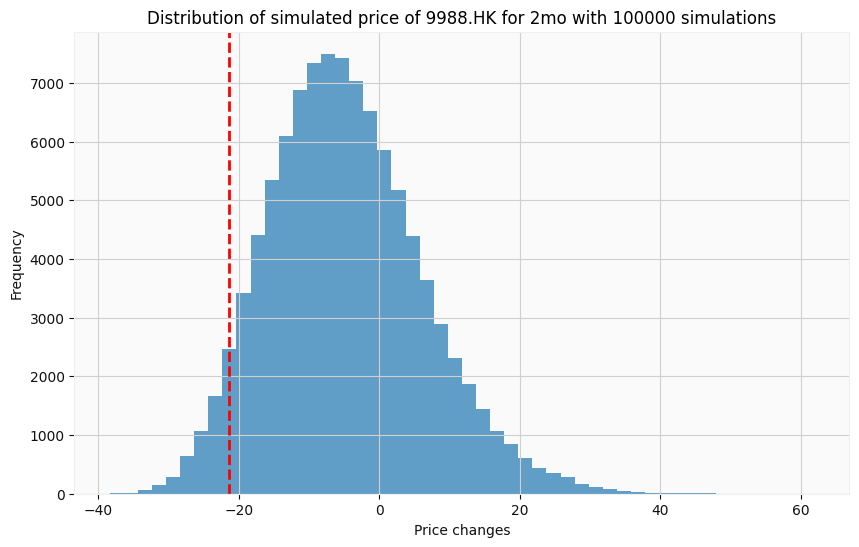

VaR is: 21.338993072144394 %
Expected Shortfall: 24.659047561579275
The maximal loss will be 526.1992450822192%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
# calculation of VaR by Monte Carlo simulation
def calcul_VaR(ticker, period,interval, iterations, confidence_level):
    data = yf.download(ticker, period=period, interval=interval)['Close']
    if len(data) < 2:
        raise ValueError("Données insuffisantes pour la période et l'intervalle spécifiés.")

    # Calculate the daily return
    returns = data.pct_change().dropna()

    # Simulation of returns by normal distibution N
    simulated_returns = np.random.normal(np.mean(returns), np.std(returns), (len(data)-1, iterations))

    # fix the initial price
    price_array = np.zeros_like(simulated_returns)
    initial_price = data.iloc[-1]
    price_array[0, :] = initial_price

    # Calculate futur price
    for t in range(1, len(data)-1):
        price_array[t] = price_array[t-1] * (1 + simulated_returns[t])

    # Calculate de price changes
    simulated_price_changes = price_array[-1] - initial_price

    # Calculat the VaR
    VaR = -np.percentile(simulated_price_changes, (1 - confidence_level) * 100)
    return VaR, simulated_price_changes

# Example
ticker = '9988.HK' # Alibab
period='2mo'
nb_simulation=100000
VaR, simulated_price_changes = calcul_VaR(ticker,'2mo','1d',nb_simulation,0.95)

# PLot the distribution
plt.figure(figsize=(10, 6))
plt.hist(simulated_price_changes[~np.isnan(simulated_price_changes)], bins=50, alpha=0.7)
plt.axvline(-VaR, color='r', linestyle='dashed', linewidth=2)
plt.title(f"Distribution of simulated price of {ticker} for {period} with {nb_simulation} simulations")
plt.xlabel("Price changes")
plt.ylabel("Frequency")
plt.show()

def calcul_Expected_Shortfall(simulated_price_changes, confidence_level):

    sorted_changes = np.sort(simulated_price_changes)

    # find the index where the VaR is overpassed
    VaR_index = int((1 - confidence_level) * len(sorted_changes))

    ES = -np.mean(sorted_changes[:VaR_index])
    return ES


print(f"VaR is: {VaR} %")
ES = calcul_Expected_Shortfall(simulated_price_changes,0.95)
print(f"Expected Shortfall: {ES}")
print(f"The maximal loss will be {VaR*ES}%")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

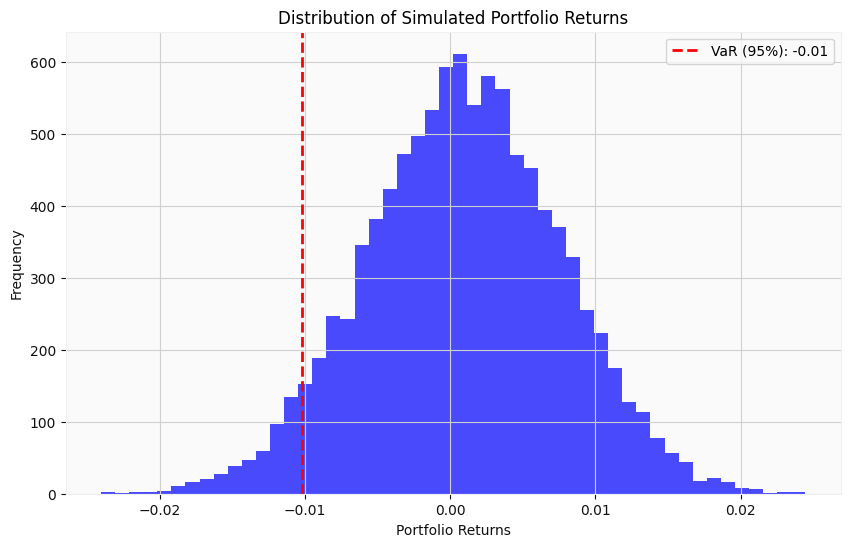

In [ ]:
import pandas as pd
# Function to simulate portfolio returns
def simulate_portfolio_returns(returns, cov_matrix, weights, iterations):
    mean_returns = returns.mean()
    simulations = np.random.multivariate_normal(mean_returns, cov_matrix, iterations)
    portfolio_returns = np.dot(simulations, weights)
    return portfolio_returns

# Retrieve historical data
historical_data = pd.DataFrame()
for asset in assets_list:
    historical_data[asset['ticker']] = yf.download(asset['ticker'], period="1y")['Close']

# Calculate daily returns
returns = historical_data.pct_change().dropna()

# Define portfolio weights
weights = np.array([1/len(assets_list)] * len(assets_list))

# Calculate covariance matrix
cov_matrix = returns.cov()

# Monte Carlo Simulation
simulated_portfolio_returns = simulate_portfolio_returns(returns, cov_matrix, weights, iterations=10000)

# Calculate VaR and ES
VaR = np.percentile(simulated_portfolio_returns, (1 - 0.95) * 100)
ES = np.mean([r for r in simulated_portfolio_returns if r < VaR])
print(f'the Value et risk of our asset liste is: {VaR*100}%')
print(f'the expected shortfull is: {ES}')
print(f'the maximal loss will be : {VaR*ES}%')

import matplotlib.pyplot as plt

# Plot the distribution of the simulated portfolio returns
plt.figure(figsize=(10, 6))
plt.hist(simulated_portfolio_returns, bins=50, alpha=0.7, color='blue')
plt.axvline(VaR, color='r', linestyle='dashed', linewidth=2, label=f'VaR (95%): {VaR:.2f}')
plt.title("Distribution of Simulated Portfolio Returns")
plt.xlabel("Portfolio Returns")
plt.ylabel("Frequency")
plt.legend()
plt.show()

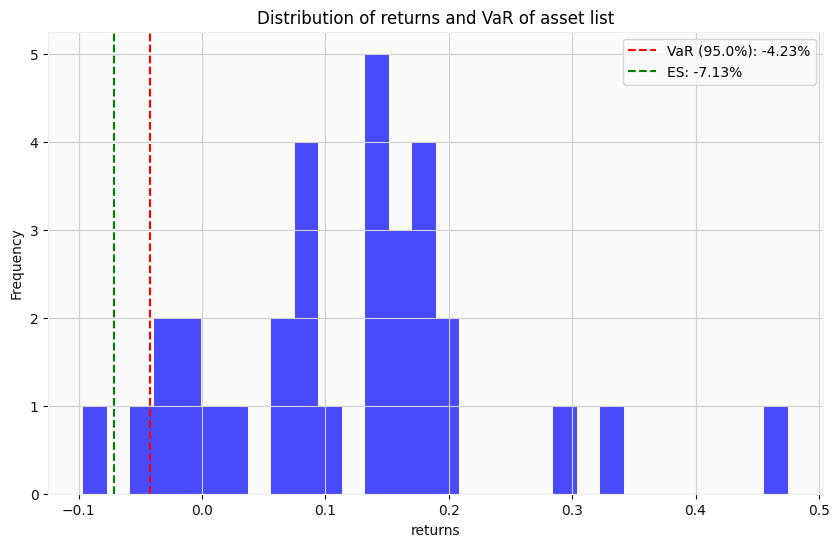

VaR: -4.23%, ES: -7.13%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def VaR_my_strategie(returns, niveau_confiance):

    returns = np.array(returns) / 100

    VaR = np.percentile(returns, (1 - niveau_confiance) * 100)

    ES = returns[returns < VaR].mean()

    plt.figure(figsize=(10, 6))
    plt.hist(returns, bins=30, alpha=0.7, color='blue')
    plt.axvline(VaR, color='red', linestyle='dashed', label=f'VaR ({niveau_confiance * 100}%): {VaR:.2%}')
    plt.axvline(ES, color='green', linestyle='dashed', label=f'ES: {ES:.2%}')

    plt.title("Distribution of returns and VaR of asset list")
    plt.xlabel("returns")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    return VaR, ES

confidence_level = 0.95
VaR, ES = VaR_my_strategie(list_return, confidence_level)
print(f"VaR: {VaR:.2%}, ES: {ES:.2%}")

In [ ]:
# The red dashed line represents the VaR at a 95% confidence level, which is approximately -4.23%.
# This implies that there is a 95% chance that daily losses will not exceed 4.23% over the period being considered.

# The green dashed line indicates the ES, which is -7.13%. This means that when losses exceed the VaR (in the worst 5% of cases), the average expected loss is 7.13%.